In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri
from fastmri.data import transforms as T
import os
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

from fastmri.data.subsample import *

%load_ext autoreload
%autoreload 2
from grappa import grappa

### Load data

In [2]:
def show_coils(data, slice_nums, cmap=None, title=''):
    fig = plt.figure(figsize=(15, 7))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
    fig.suptitle(title)
    plt.show()
    
def naive_recon(masked_kspace):
    sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
    sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
    sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
    return np.abs(sampled_image_rss.numpy())

(16, 12, 640, 320) (number of slices, number of coils, height, width)


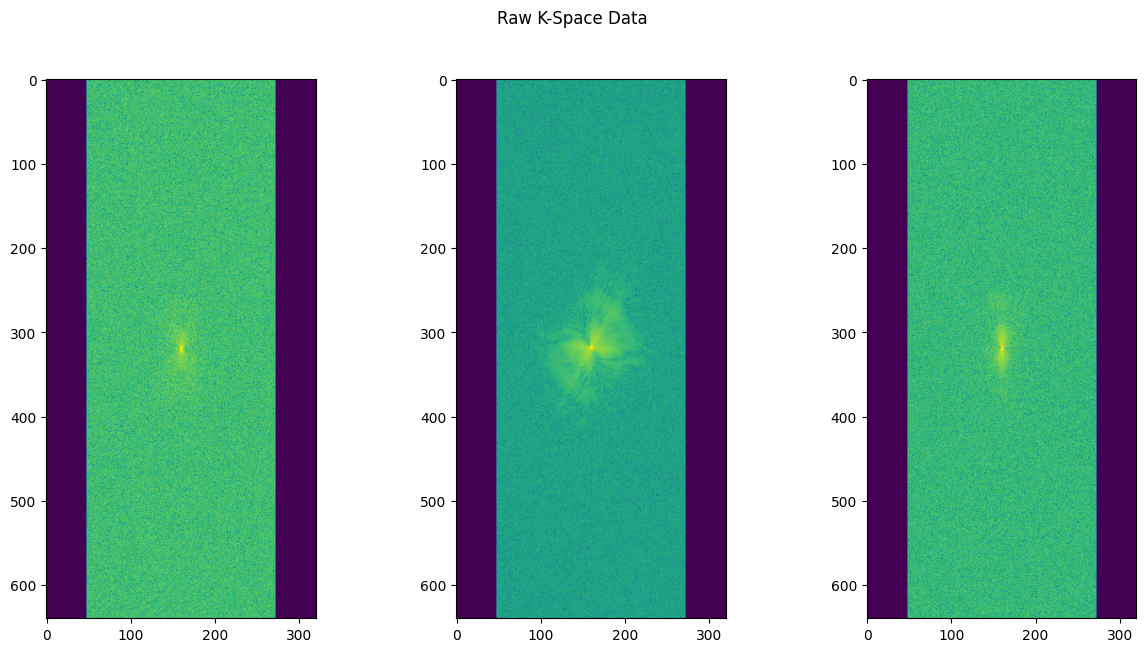

(16, 320, 320)


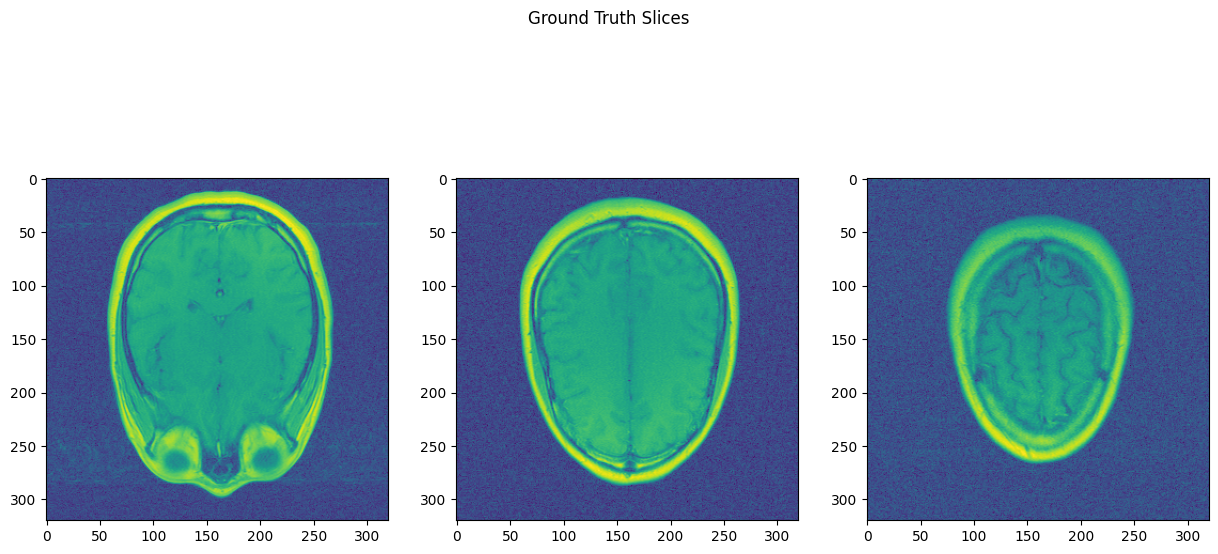

torch.Size([12, 640, 320, 2])


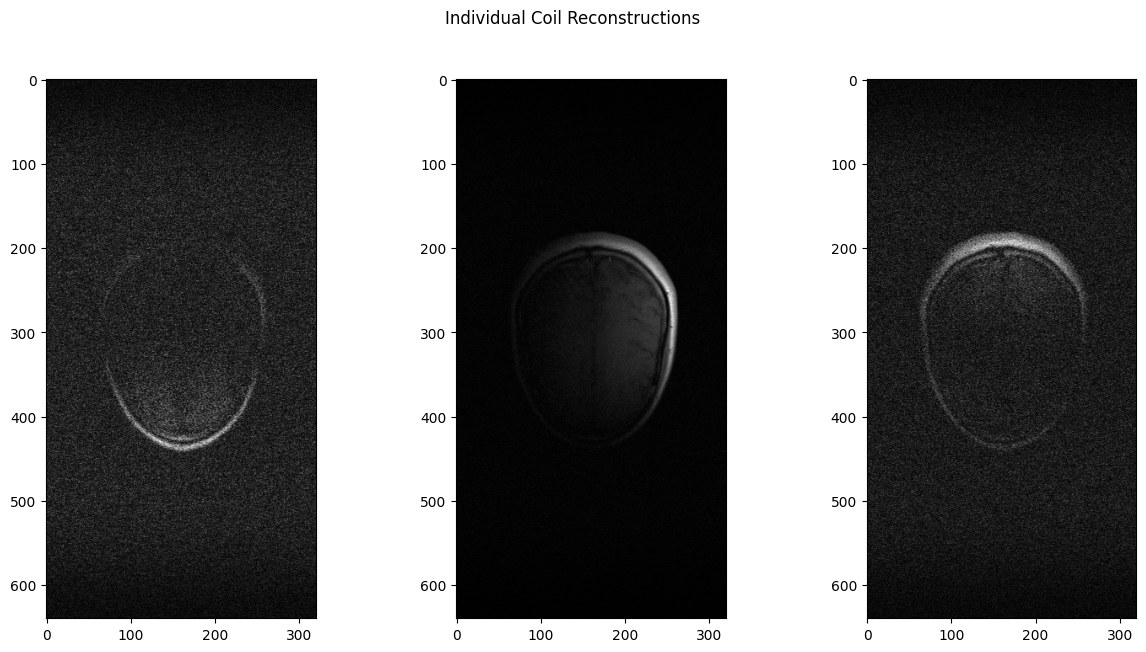

Text(0.5, 1.0, 'Sum of Square Reconstruction')

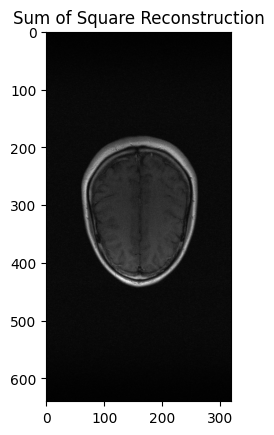

In [ ]:
base_path = '/adg-bulk2/fastmri/'
dataset = 'multicoil_val/'
# file_name = 'file_brain_AXT2_210_6001947.h5'
file_name = 'file_brain_AXT1_202_2020270.h5'
hf = h5py.File(os.path.join(base_path, dataset, file_name), 'r')
volume_kspace = hf['kspace'][()]
print(volume_kspace.shape, '(number of slices, number of coils, height, width)')
slice_kspace = volume_kspace[6] # Choosing the 10-th slice of this volume
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10], title='Raw K-Space Data')  # This shows coils 0, 5 and 10

gt = hf['reconstruction_rss'][()]
print(gt.shape)
show_coils(np.log(gt + 1e-9), [0, 5, 10], title='Ground Truth Slices')  # This shows coils 0, 5 and 10

slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
show_coils(slice_image_abs, [0, 5, 10], cmap='gray', title='Individual Coil Reconstructions')

slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')
plt.title('Sum of Square Reconstruction')

### Grappa Reconstruction

In [4]:
class CenterMaskFunc(MaskFunc):
    """
    The mask selects the center columns from the input k-space data. If the
    k-space data has N columns, the mask picks out:
        N_low_freqs = (N * center_fraction) columns in the center
           corresponding to low-frequencies.

    It is possible to use multiple center_fractions, in which
    case one possible (center_fraction, ) is chosen uniformly at
    random each time the ``CenterMaskFunc`` object is called.

    For example, if and center_fractions = [0.08, 0.04],
    then there is a 50% probability a 8% center fraction is selected.
    
    This mask function can be used to generate the acquired auto-calibration 
    signal (ACS) for GRAPPA reconstruction.
    """

    def calculate_acceleration_mask(
        self,
        num_cols: int,
        acceleration: int,
        offset: Optional[int],
        num_low_frequencies: int,
    ) -> np.ndarray:
        prob = (num_cols / acceleration - num_low_frequencies) / (
            num_cols - num_low_frequencies
        )

        return np.zeros(num_cols)

/tmp/ipykernel_74931/1562147637.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  show_coils(np.log(np.abs(center_masked_kspace[...,0]+1j*center_masked_kspace[...,1]) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10


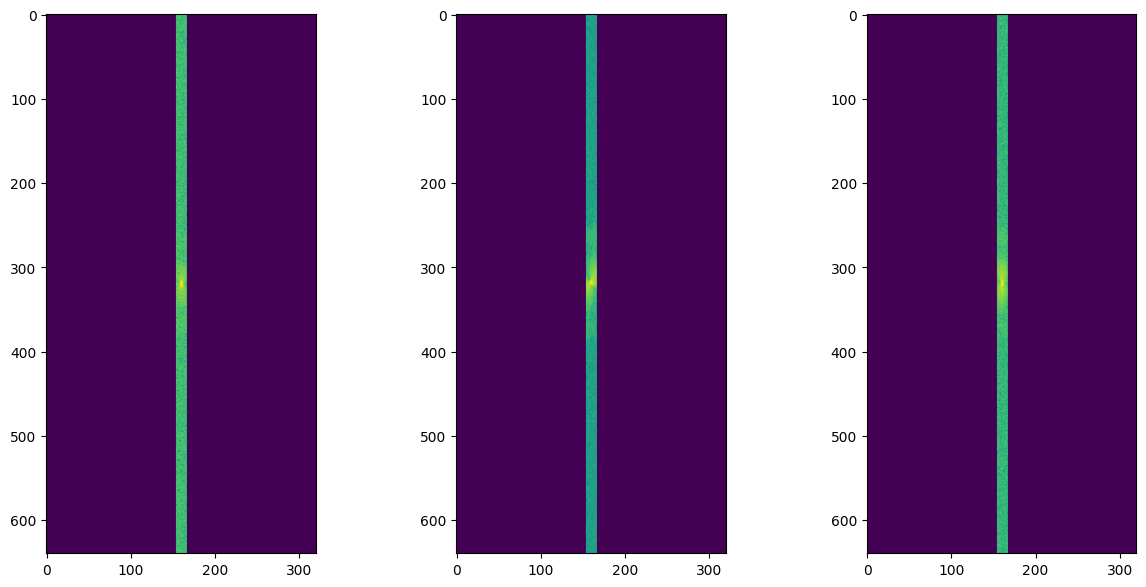

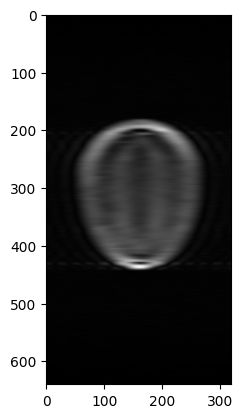

In [5]:
# Center Mask
center_mask_func = CenterMaskFunc(center_fractions=[0.04], accelerations=[8])
center_masked_kspace, mask, _ = T.apply_mask(slice_kspace2, center_mask_func)   # Apply the mask to k-space
show_coils(np.log(np.abs(center_masked_kspace[...,0]+1j*center_masked_kspace[...,1]) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10
plt.imshow(naive_recon(center_masked_kspace), cmap='gray')

/tmp/ipykernel_74931/3678716780.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  show_coils(np.log(np.abs(equi_masked_kspace[...,0]+1j*equi_masked_kspace[...,1]) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10


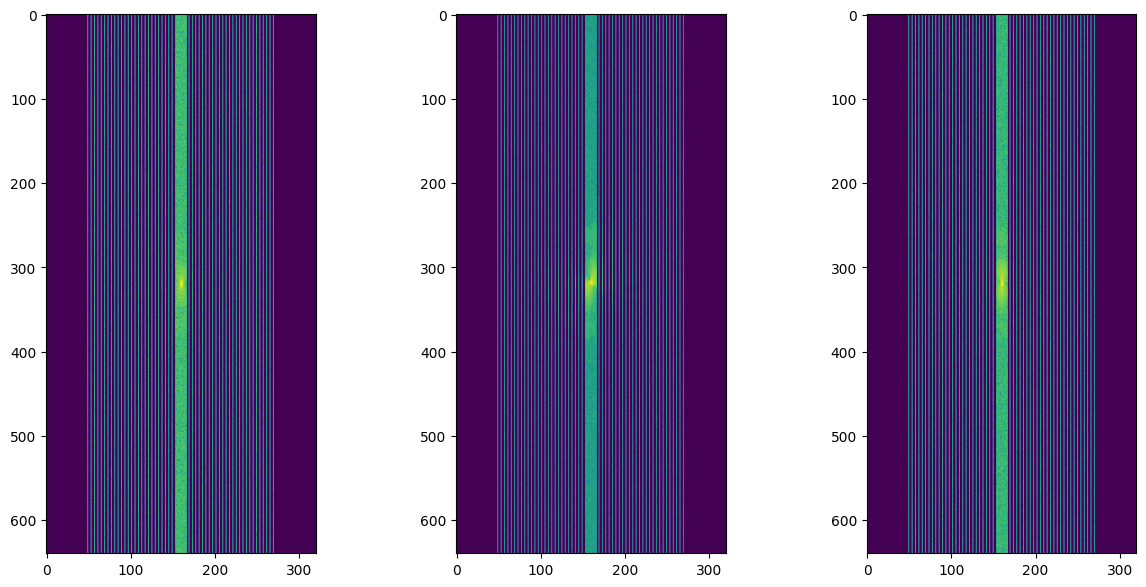

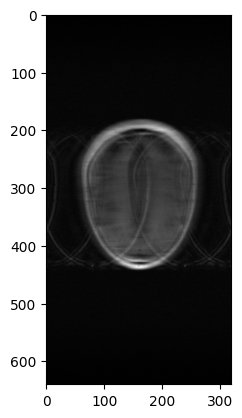

In [11]:
# Equi-spaced Mask
equi_mask_func = EquiSpacedMaskFunc(center_fractions=[0.04], accelerations=[4])
equi_masked_kspace, mask, _ = T.apply_mask(slice_kspace2, equi_mask_func)   # Apply the mask to k-space
show_coils(np.log(np.abs(equi_masked_kspace[...,0]+1j*equi_masked_kspace[...,1]) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10
plt.show()
plt.imshow(naive_recon(equi_masked_kspace), cmap='gray')

In [ ]:
equi_masked_kspace, mask, _ = T.apply_mask(T.to_tensor(volume_kspace), equi_mask_func)
equi_masked_kspace = equi_masked_kspace[...,0]+1j*equi_masked_kspace[...,1]
center_masked_kspace = volume_kspace[...,volume_kspace.shape[-1]//2-volume_kspace.shape[-1]//50:volume_kspace.shape[-1]//2+volume_kspace.shape[-1]//50]

(16, 12, 640, 12)


In [29]:
grappa_recon = grappa(equi_masked_kspace, torch.tensor(center_masked_kspace), kernel_size=[5, 5], lam=0.01, verbose=True, coils=[], gpu=False)

Working on all coils
 
Orientation: (0, 1, 2, 3)
 
Calculating calibration matrix...
torch.Size([16, 300, 300])
 
Coil #0, total of 12 coils to reconstruct
Zero padding k-space data...
Estimating missing k-space samples...
 
Coil #1, total of 12 coils to reconstruct
Zero padding k-space data...
Estimating missing k-space samples...
 
Coil #2, total of 12 coils to reconstruct
Zero padding k-space data...
Estimating missing k-space samples...
 
Coil #3, total of 12 coils to reconstruct
Zero padding k-space data...
Estimating missing k-space samples...
 
Coil #4, total of 12 coils to reconstruct
Zero padding k-space data...
Estimating missing k-space samples...
 
Coil #5, total of 12 coils to reconstruct
Zero padding k-space data...
Estimating missing k-space samples...
 
Coil #6, total of 12 coils to reconstruct
Zero padding k-space data...
Estimating missing k-space samples...


W1207 16:20:52.055000 74931 torch/_dynamo/convert_frame.py:844] [7/8] torch._dynamo hit config.cache_size_limit (8)
W1207 16:20:52.055000 74931 torch/_dynamo/convert_frame.py:844] [7/8]    function: 'torch_dynamo_resume_in_est_kernel_at_132' (/afs/csail.mit.edu/u/r/rmei/MRWhy/grappa.py:132)
W1207 16:20:52.055000 74931 torch/_dynamo/convert_frame.py:844] [7/8]    last reason: 7/0: L['idxc_flat'] == 12                                        
W1207 16:20:52.055000 74931 torch/_dynamo/convert_frame.py:844] [7/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1207 16:20:52.055000 74931 torch/_dynamo/convert_frame.py:844] [7/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


 
Coil #7, total of 12 coils to reconstruct
Zero padding k-space data...
Estimating missing k-space samples...
 
Coil #8, total of 12 coils to reconstruct
Zero padding k-space data...
Estimating missing k-space samples...
 
Coil #9, total of 12 coils to reconstruct
Zero padding k-space data...
Estimating missing k-space samples...
 
Coil #10, total of 12 coils to reconstruct
Zero padding k-space data...
Estimating missing k-space samples...
 
Coil #11, total of 12 coils to reconstruct
Zero padding k-space data...
Estimating missing k-space samples...
torch.Size([16, 12, 640, 320]) torch.Size([16, 12, 640, 320]) (0, 1, 2, 3)
cpu cpu


/tmp/ipykernel_74931/1854989584.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  show_coils(np.log(np.abs(grappa_recon.cpu()[10]) + 1e-9), [0])


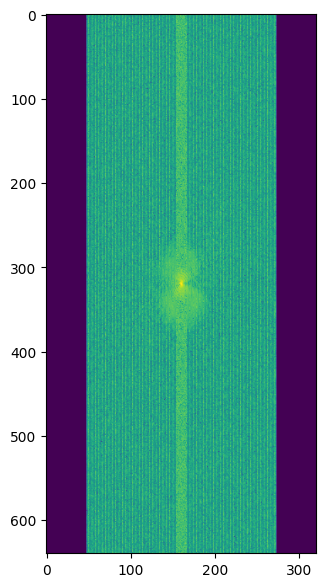

In [30]:
show_coils(np.log(np.abs(grappa_recon.cpu()[10]) + 1e-9), [0])

In [31]:
grappa_recon.shape

torch.Size([16, 12, 640, 320])

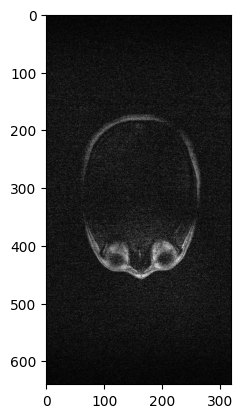

In [32]:
grappa_recon2 = T.to_tensor(grappa_recon.cpu())
slice_image = fastmri.ifft2c(grappa_recon2[0,0,:,:])          # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)
slice_image_abs.shape
plt.imshow(slice_image_abs, cmap='gray')

In [33]:
from pygrappa.mdgrappa import mdgrappa
res = mdgrappa(equi_masked_kspace.numpy(), center_masked_kspace, kernel_size=(5, 5, 5), coil_axis=1)

/afs/csail.mit.edu/u/r/rmei/MRWhy/.venv/lib/python3.12/site-packages/pygrappa/mdgrappa.py:132: RuntimeWarning: invalid value encountered in scalar divide
  Ws = train_kernels(kspace.astype(np.complex128), nc, A.astype(np.complex128), P,


In [38]:
a = np.array([0,0,0])
a+= 1,1,1
a

array([1, 1, 1])

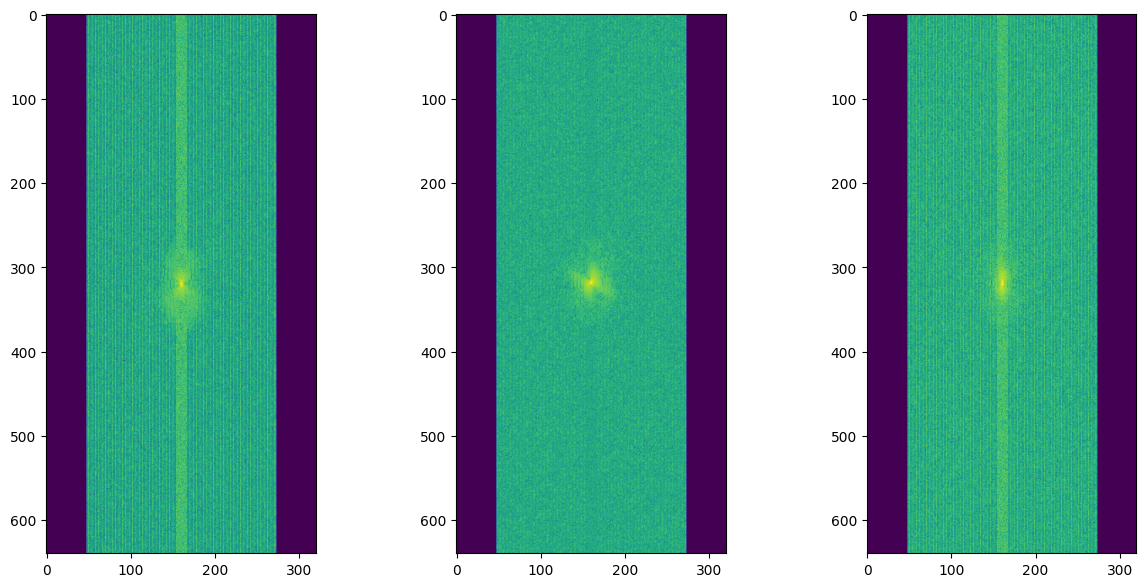

In [35]:
show_coils(np.log(np.abs(res[10]) + 1e-9), [0, 5, 10])

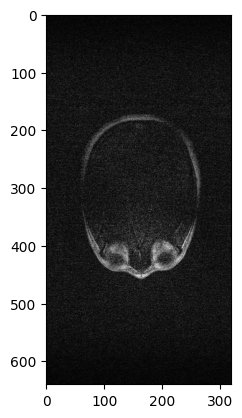

In [36]:
grappa_recon2 = T.to_tensor(res)
slice_image = fastmri.ifft2c(grappa_recon2[0,0,:,:])          # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)
slice_image_abs.shape
plt.imshow(slice_image_abs, cmap='gray')